<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Generando datos con _variational autoencoders_<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-04-01</small></i></div>
                                                  

***

## Introducción

Los variational autoencoders (VAEs) son una clase de modelos generativos que se han vuelto muy populares en los últimos años, gracias a su capacidad para generar imágenes y otros tipos de datos de alta calidad.

A diferencia de los autoencoders tradicionales, que se utilizan principalmente para la reducción de la dimensionalidad y la compresión de datos, los VAEs permiten la generación de nuevas instancias de datos, a partir de la codificación de los datos de entrada.

## Objetivos

Vamos a implementar un VAE en Keras en el ejemplo concreto de la generación de imágenes de dígitos manuscritos usando el _dataset_ `mnist`.Nuestro objetivo será entrenar un VAE en este conjunto de datos, de tal manera que podamos utilizar el modelo para generar nuevas imágenes de dígitos, que se parezcan a las imágenes originales.

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del notebook.

In [1]:
import itertools
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import tensorflow as tf

Configuraremos también algunos parámetros para adecuar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Conjunto de datos

Como no, vamos a seguir trabajando con el conjunto de datos `mnist`. A estas alturas lo conocemos bastante bien.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255, x_test / 255

print(f'Training shape: {x_train.shape} input, {y_train.shape} output')
print(f'Test shape:     {x_test.shape} input, {y_test.shape} output')

Training shape: (60000, 28, 28) input, (60000,) output
Test shape:     (10000, 28, 28) input, (10000,) output


## Implementación del _variational autoencoder_

Vamos a realizar una implementación similar a la del anterior autoencoder. Sin embargo, mientras que en un autoencoder básico la codificación latente es simplemente una representación comprimida de los datos de entrada, en un VAE, la codificación latente también se utiliza para generar nuevas muestras de datos, es decir, datos que no se encuentran en el conjunto original de datos.

Esto se logra a través de la introducción de capas adicionales para calcular la media y la varianza de la distribución latente. Para ello necesitaremos además, un término de divergencia KL (una medida de similitud) para garantizar que la distribución latente se aproxime a una distribución normal estándar, usando dicha similitud como parte del loss para intentar que esta tiena a 0 (máxima similitud entre distribuciones).

In [4]:
class VariationalAutoencoder(tf.keras.models.Model):

    def __init__(self, input_dim, latent_dim):
        super().__init__()
        
        flatten_dim = None
        if isinstance(input_dim, (list, tuple)):
            flatten_dim = math.prod(input_dim)
        elif isinstance(input_dim, int):
            flatten_dim = input_dim
            input_dim = (input_dim,)
        else:
            raise ValueError('Argument input_dim must be a tuple or an int')

        # Encoder
        encoder_input = tf.keras.layers.Input(shape=input_dim)
        encoder_flatten = tf.keras.layers.Flatten()(encoder_input)
        
        z_mean = tf.keras.layers.Dense(latent_dim)(encoder_flatten)
        z_log_sigma = tf.keras.layers.Dense(latent_dim)(encoder_flatten)
        
        def sampling(args):
            z_mean, z_log_sigma = args
            epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
            return z_mean + tf.math.exp(z_log_sigma) * epsilon

        z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])
        
        self.encoder = tf.keras.models.Model(encoder_input, [z_mean, z_log_sigma, z], name='encoder')
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(flatten_dim, activation='sigmoid'),
            tf.keras.layers.Reshape(input_dim)
        ])

    def call(self, inputs):
        z_mean, z_sigma, z = self.encoder(inputs)
        reconstructed_input = self.decoder(z)
        
        # Añadimos la divergencia KL como loss
        kl_loss = -tf.reduce_mean(z_sigma - tf.square(z_mean) - tf.exp(z_sigma) + 1) / 2
        self.add_loss(kl_loss)

        return reconstructed_input

Ahora crearemos nuestro VAE.

In [5]:
LATENT_DIM = 128
IMG_SIZE = (28, 28)

vae = VariationalAutoencoder(IMG_SIZE, LATENT_DIM)
vae.compile(loss='binary_crossentropy', optimizer='adam')

Y lo entrenamos

In [6]:
history = vae.fit(x_train, x_train, shuffle=True, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2165
Epoch 2/50
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1380
Epoch 3/50
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1228
Epoch 4/50
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1172
Epoch 5/50
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1143
Epoch 6/50
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1120
Epoch 7/50
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1109
Epoch 8/50
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1098
Epoch 9/50
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1098
Epoch 10/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1089
Epoch 11/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1084
Epoch 12/50
1875/1875 [==============================] - 10s 5ms/step - lo

Veamos cómo evoluciona el _loss_ en el entrenamiento:

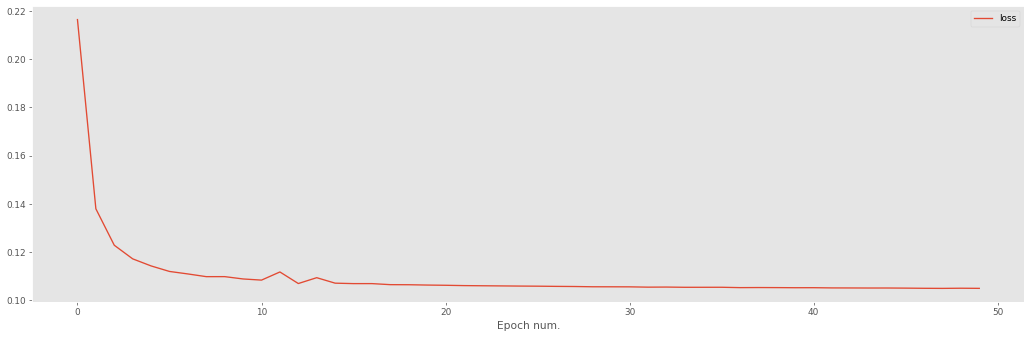

In [7]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Esta arquitectura es un poco más compleja, lo que se traduce en un entrenamiento más largo. Veamos cómo reconstruye nuestras imágenes de entrenamiento:

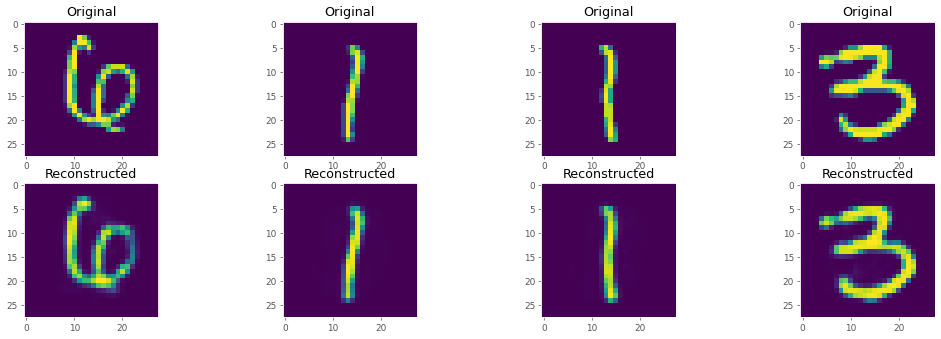

In [8]:
n = 4
images = np.array(random.sample(list(x_train), n))

encoded, _, _ = vae.encoder(images)
decoded = vae.decoder(encoded).numpy()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

Ahora vamos con las de test:

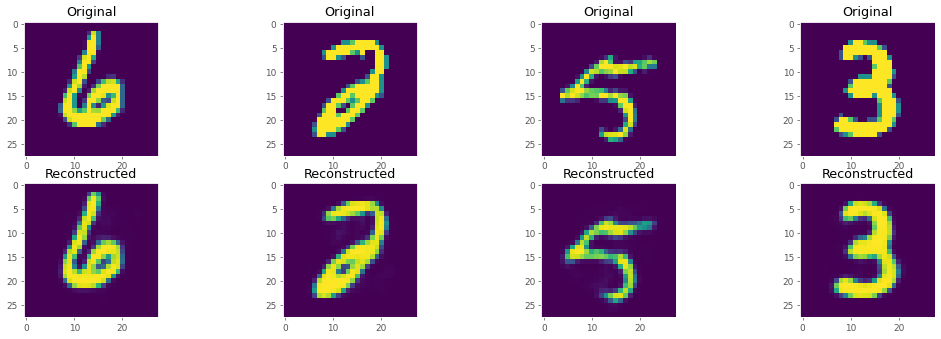

In [9]:
images = np.array(random.sample(list(x_test), n))

encoded, _, _ = vae.encoder(images)
decoded = vae.decoder(encoded).numpy()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

Este tipo de redes tienen la ventaja que la codificación la realizan en un espacio latente en el que las interpolaciones entre elementos con continuas, en el sentido de que comparten características entre los elementos que representan.

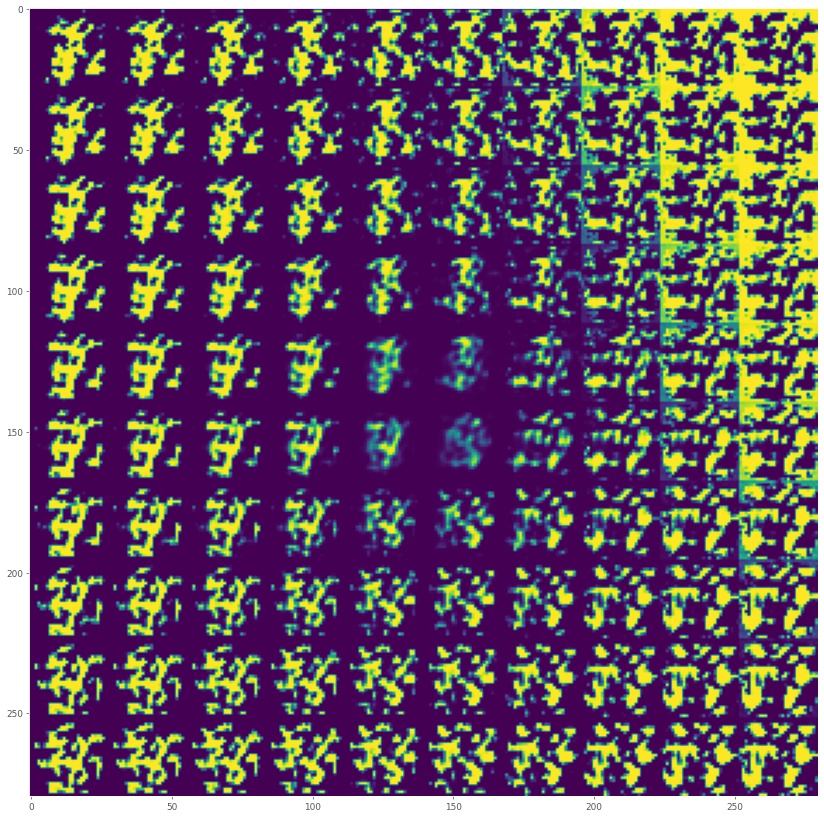

In [10]:
# 100 imágenes (matriz de 10 x 10) de 28 x 28
num_digits = 10
size=28
figure = np.zeros((IMG_SIZE[0] * num_digits, IMG_SIZE[1] * num_digits))
# Recorremos el espacio latente entre los valores mínimos y máximos de estos
encoded_test, _, _ = vae.encoder(x_train)
min_z, max_z = np.min(encoded_test), np.max(encoded_test)
grid_x = np.linspace(min_z, max_z, num_digits)
grid_y = np.linspace(min_z, max_z, num_digits)
# Imprimimos las imágenes que se corresponden con ese espacio
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = [(xi if i % 2 == 1 else yi) for i in range(LATENT_DIM)]
        x_decoded = vae.decoder.predict([z_sample], verbose=0)
        digit = x_decoded[0].reshape(size, size)
        figure[i * size: (i + 1) * size, j * size: (j + 1) * size] = digit

plt.figure(figsize=(16, 16))
plt.imshow(figure)
plt.show()

Sin embargo, este tipo de redes no son idóneas para ruido. Por ejemplo, veamos qué pasa cuando añadimos un mínimo de ruido a nuestras imágenes:

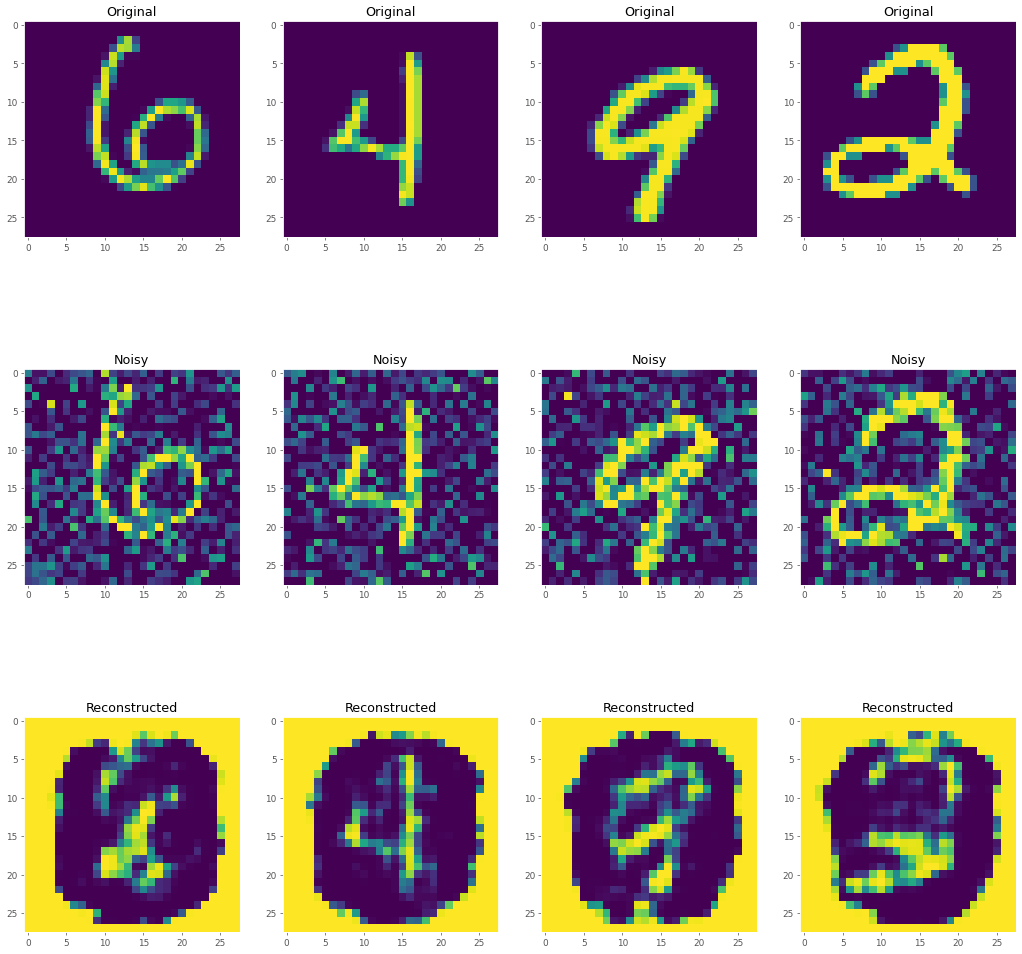

In [11]:
images = np.array(random.sample(list(x_test), n))
noise_factor = 0.3
noisy_images = images + noise_factor * tf.random.normal(shape=images.shape)
noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0, clip_value_max=1)

encoded, _, _ = vae.encoder(noisy_images)
decoded = vae.decoder(encoded).numpy()

plt.figure(figsize=(20,20)) 
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i])
    plt.title('Original')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i])
    plt.title('Noisy')

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded[i])
    plt.title('Reconstructed')

## Conclusiones

Hemos implementado un VAE en Keras que ha sido capaz de codificar y decodificar dígitos escritos a mano. Al igual que ocurría con los _autoencoders_ básicos, las codificación y posterior decodificación se ha realizado casi sin pérdida, con la ventaja añadida de que las codificaciones cercanas a varios "conjuntos de ejemplos" los interpolan, adquiriendo éstas características de estos conjuntos.

Sin embargo, hemos visto que pueden ser deficientes en algunos casos, por ejemplo en el de la eliminación de ruido.

Esta implementación puede servir de base para la exploración de otras arquitecturas más complejas en otros problemas, asíq ue no os cortéis de usarlas y de explorar.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>